In [1]:
import os
import nltk
import pandas as pd
import numpy as np
from pickle import load

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib qt

In [2]:
class Net(nn.Module):
    def __init__(self,input_len):
        super().__init__()
        
        # define the layers
        self.fc1 = nn.Linear(input_len,512) # 128
        self.hid1 = nn.Linear(512,256)
        self.hid2 = nn.Linear(256+input_len,256)
        self.hid3 = nn.Linear(256,64)
        self.hid4 = nn.Linear(64+256,128)
        #self.hid5 = nn.Linear(128,8)
        self.out = nn.Linear(128,8)
        
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        s = F.relu(self.fc1(x))
        # s = self.dropout(s)
        
        s = F.relu(self.hid1(s))
        s = self.dropout(s)
        
        s = torch.cat([x,s],1)
        s = F.relu(self.hid2(s))
        s1 = self.dropout(s)
        
        s = F.relu(self.hid3(s1))
        # s = self.dropout(s)
        
        s = torch.cat([s1,s],1)
        s = F.relu(self.hid4(s))
        s = self.dropout(s)
        
        #s = F.relu(self.hid5(s))
        
        s = self.out(s)
        
        return F.log_softmax(s, dim=1)

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(70,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [3]:
def plot_loss(check,epoch,loss,acc=0):
    ax.plot(epoch,loss,'ro-')
    if (epoch%check==0):
        ax.plot(epoch,acc,'bo-')
        ax.text(epoch,acc,f"{acc}")
    plt.show()

In [4]:
le = load(open('D:/DataMining/HW2_kaggle/clean_data/label.pkl','rb'))
df_label = pd.read_csv("D:/DataMining/HW2_kaggle/emotion.csv")
onehot = OneHotEncoder()

In [5]:
feature_size = 249
df_data_test = pd.read_csv("D:/DataMining/HW2_kaggle/clean_data/evaluation_id.csv")
X_evaluation = torch.from_numpy(np.load("D:/DataMining/HW2_kaggle/clean_data/FFT160180/X_evaluation.npy"))
X_evaluation.reshape([len(X_evaluation),1,feature_size]).float()

X_train = np.load("D:/DataMining/HW2_kaggle/clean_data/FFT160180/X_train.npy")
X_train = torch.from_numpy(X_train).reshape([len(X_train),1,feature_size])
y_train = torch.from_numpy(np.load("D:/DataMining/HW2_kaggle/clean_data/FFT160180/y_train.npy")).long()
#y_train = torch.nn.functional.one_hot(y_train).reshape([len(y_train),1,8])

X_test = np.load("D:/DataMining/HW2_kaggle/clean_data/FFT160180/X_test.npy")
X_test = torch.from_numpy(X_test).reshape([len(X_test),1,feature_size])
y_test = torch.from_numpy(np.load("D:/DataMining/HW2_kaggle/clean_data/FFT160180/y_test.npy")).long()
#y_test = torch.nn.functional.one_hot(y_test)

In [6]:
batch = 27000
epochs = 2000
check = 50
acc_best = 0

LOSS = []
Precision = []

# train
torch_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset = torch_train, batch_size = batch, shuffle = True, num_workers = 6)

# test
torch_test = TensorDataset(X_test, y_test)
tset_loader = DataLoader(dataset = torch_test, batch_size = batch, shuffle = True, num_workers = 6)

# evaluation
torch_val = TensorDataset(X_evaluation, torch.from_numpy(np.array(df_data_test.index)))
val_loader = DataLoader(dataset = torch_val, batch_size = batch, shuffle = False, num_workers = 6)

In [7]:
input_len = len(X_train.T)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#device= 'cpu'
model = Net(input_len).to(device) # batch
optimizer = optim.Adam(model.parameters(), lr = 0.001)
model.train()

cuda:0


Net(
  (fc1): Linear(in_features=249, out_features=512, bias=True)
  (hid1): Linear(in_features=512, out_features=256, bias=True)
  (hid2): Linear(in_features=505, out_features=256, bias=True)
  (hid3): Linear(in_features=256, out_features=64, bias=True)
  (hid4): Linear(in_features=320, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=8, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(epochs):
    for X,y in train_loader:
        X = X.float().to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(X.view(-1, 1 * input_len))
        #loss = nn.CrossEntropyLoss()(pred, y)
        loss = F.nll_loss(pred, y)
        loss.backward()
        optimizer.step()
        
    print(f'epoch:{epoch}, loss:{loss}')
    LOSS.append(loss)
    
    if epoch%check == 0:
        model.eval()
        corr = 0
        total = 0
        with torch.no_grad():
            for X,y in train_loader:
                X = X.float().to(device)
                y = y.to(device)
                out = model(X.view(-1,input_len))
                corr += (torch.argmax(out,dim=1) == y.squeeze()).sum().item()
                total += y.size(0)
        acc = round(corr/total,3)
        Precision.append(acc)
        path = f"D:/DataMining/HW2_kaggle/model_log_FFT/{epoch}-model-parameters.pt"
        torch.save(model.state_dict(), path)
        if acc > acc_best:
            acc_best = acc
            torch.save(model.state_dict(), "D:/DataMining/HW2_kaggle/model_log_FFT/best-model-parameters.pt")
        print(f'Training data Accuracy : {corr}/{total} = {round(corr/total, 3)}')
        model.train()
    plot_loss(check,epoch,loss.cpu().detach().numpy(),acc)
    
model.eval()

corr = 0
total = 0
with torch.no_grad():
    for X,y in train_loader:
        X = X.float().to(device)
        y = y.to(device)
        out = model(X.view(-1,input_len))
        corr += (torch.argmax(out,dim=1) == y.squeeze()).sum().item()
        total += y.size(0)
        
acc = round(corr/total,3)
Precision.append(acc)
if acc > acc_best:
    acc_best = acc
    torch.save(model.state_dict(), "D:/DataMining/HW2_kaggle/model_log_FFT/best-model-parameters.pt")
            
print(f'Training data Accuracy : {corr}/{total} = {round(corr/total, 3)}')

epoch:0, loss:1.7955116033554077
Training data Accuracy : 386849/1091672 = 0.354
epoch:1, loss:1.7762635946273804
epoch:2, loss:1.7641451358795166
epoch:3, loss:1.7614154815673828
epoch:4, loss:1.7535640001296997
epoch:5, loss:1.740766167640686
epoch:6, loss:1.746897578239441
epoch:7, loss:1.732366681098938
epoch:8, loss:1.7312082052230835
epoch:9, loss:1.7229502201080322
epoch:10, loss:1.7214148044586182
epoch:11, loss:1.7310534715652466
epoch:12, loss:1.731738805770874
epoch:13, loss:1.7143592834472656
epoch:14, loss:1.7185776233673096
epoch:15, loss:1.7160879373550415
epoch:16, loss:1.7174314260482788
epoch:17, loss:1.7155007123947144
epoch:18, loss:1.710903525352478
epoch:19, loss:1.7139251232147217
epoch:20, loss:1.6920969486236572
epoch:21, loss:1.7089424133300781
epoch:22, loss:1.703829288482666
epoch:23, loss:1.7055175304412842
epoch:24, loss:1.7104895114898682
epoch:25, loss:1.6997178792953491
epoch:26, loss:1.711100459098816
epoch:27, loss:1.6881545782089233
epoch:28, loss:1.

epoch:232, loss:1.6535789966583252
epoch:233, loss:1.6570338010787964
epoch:234, loss:1.6481187343597412
epoch:235, loss:1.6551539897918701
epoch:236, loss:1.6623297929763794
epoch:237, loss:1.6479686498641968
epoch:238, loss:1.650057315826416
epoch:239, loss:1.646229863166809
epoch:240, loss:1.6547937393188477
epoch:241, loss:1.6539320945739746
epoch:242, loss:1.646659016609192
epoch:243, loss:1.655827522277832
epoch:244, loss:1.6614887714385986
epoch:245, loss:1.6642041206359863
epoch:246, loss:1.6404539346694946
epoch:247, loss:1.6587566137313843
epoch:248, loss:1.663342833518982
epoch:249, loss:1.6557680368423462
epoch:250, loss:1.6528246402740479
Training data Accuracy : 435776/1091672 = 0.399
epoch:251, loss:1.6427034139633179
epoch:252, loss:1.6506823301315308
epoch:253, loss:1.6471740007400513
epoch:254, loss:1.6322718858718872
epoch:255, loss:1.6502721309661865
epoch:256, loss:1.6598193645477295
epoch:257, loss:1.653224229812622
epoch:258, loss:1.6538628339767456
epoch:259, lo

epoch:461, loss:1.635895013809204
epoch:462, loss:1.6422109603881836
epoch:463, loss:1.642194151878357
epoch:464, loss:1.6261825561523438
epoch:465, loss:1.6289551258087158
epoch:466, loss:1.6335780620574951
epoch:467, loss:1.6255769729614258
epoch:468, loss:1.6260888576507568
epoch:469, loss:1.6432907581329346
epoch:470, loss:1.640458345413208
epoch:471, loss:1.6421706676483154
epoch:472, loss:1.640386700630188
epoch:473, loss:1.6263920068740845
epoch:474, loss:1.6439765691757202
epoch:475, loss:1.634658694267273
epoch:476, loss:1.642583966255188
epoch:477, loss:1.6383020877838135
epoch:478, loss:1.6438062191009521
epoch:479, loss:1.644758701324463
epoch:480, loss:1.6423085927963257
epoch:481, loss:1.6327259540557861
epoch:482, loss:1.6357330083847046
epoch:483, loss:1.6342028379440308
epoch:484, loss:1.6365783214569092
epoch:485, loss:1.6437807083129883
epoch:486, loss:1.6285642385482788
epoch:487, loss:1.6304683685302734
epoch:488, loss:1.64322030544281
epoch:489, loss:1.63731825351

epoch:692, loss:1.6288508176803589
epoch:693, loss:1.6268373727798462
epoch:694, loss:1.6219674348831177
epoch:695, loss:1.6209512948989868
epoch:696, loss:1.6303110122680664
epoch:697, loss:1.6370707750320435
epoch:698, loss:1.6157810688018799
epoch:699, loss:1.628712773323059
epoch:700, loss:1.616902232170105
Training data Accuracy : 448617/1091672 = 0.411
epoch:701, loss:1.6339391469955444
epoch:702, loss:1.6226104497909546
epoch:703, loss:1.6294931173324585
epoch:704, loss:1.6251786947250366
epoch:705, loss:1.6217401027679443
epoch:706, loss:1.6212040185928345
epoch:707, loss:1.6261584758758545
epoch:708, loss:1.6393378973007202
epoch:709, loss:1.6253145933151245
epoch:710, loss:1.6243596076965332
epoch:711, loss:1.6375153064727783
epoch:712, loss:1.6373741626739502
epoch:713, loss:1.6248342990875244
epoch:714, loss:1.6299902200698853
epoch:715, loss:1.625343680381775
epoch:716, loss:1.6124235391616821
epoch:717, loss:1.6231305599212646
epoch:718, loss:1.6162887811660767
epoch:719,

epoch:921, loss:1.599098563194275
epoch:922, loss:1.6179600954055786
epoch:923, loss:1.6292725801467896
epoch:924, loss:1.617895483970642
epoch:925, loss:1.6168514490127563
epoch:926, loss:1.6375905275344849
epoch:927, loss:1.6056386232376099
epoch:928, loss:1.6253979206085205
epoch:929, loss:1.6227692365646362
epoch:930, loss:1.6192387342453003
epoch:931, loss:1.6145200729370117
epoch:932, loss:1.6150225400924683
epoch:933, loss:1.6153740882873535
epoch:934, loss:1.610262155532837
epoch:935, loss:1.6103109121322632
epoch:936, loss:1.5992449522018433
epoch:937, loss:1.6370819807052612
epoch:938, loss:1.621054768562317
epoch:939, loss:1.6164116859436035
epoch:940, loss:1.6120046377182007
epoch:941, loss:1.6180449724197388
epoch:942, loss:1.620736002922058
epoch:943, loss:1.6142830848693848
epoch:944, loss:1.6359518766403198
epoch:945, loss:1.618153691291809
epoch:946, loss:1.6257476806640625
epoch:947, loss:1.6139194965362549
epoch:948, loss:1.6142641305923462
epoch:949, loss:1.62314665

KeyboardInterrupt: 

In [9]:
# testing
corr = 0
total = 0
pred = []
true = []
with torch.no_grad():
    for X,y in tset_loader:
        X = X.float().to(device)
        y = y.to(device)
        out = model(X.view(-1,input_len))
        corr += (torch.argmax(out,dim=1) == y.long().squeeze()).sum().item()
        total += y.size(0)
        Pre = torch.argmax(out,dim=1).cpu().numpy()
        pred.append(Pre)
        true.append(y.long().squeeze().cpu().numpy())
print(f'Testing data Accuracy : {corr}/{total} = {round(corr/total, 3)}')

Testing data Accuracy : 138206/363891 = 0.38


In [10]:
y_pred = []
for sublist in pred:
    for item in sublist:
        y_pred.append(item)
y_True = []
for sublist in true:
    for item in sublist:
        y_True.append(item)

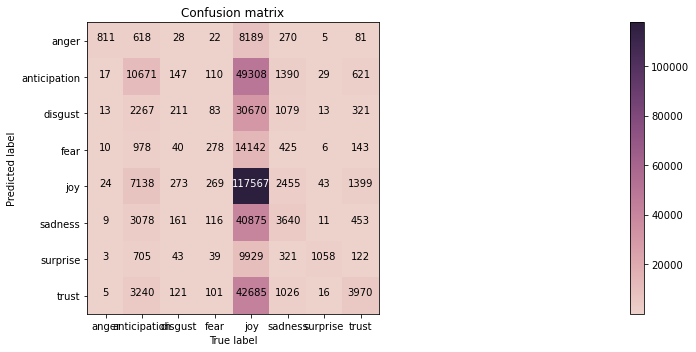

In [11]:
cm = confusion_matrix(y_true=y_True, y_pred=y_pred)

%matplotlib inline
my_tags = pd.unique(df_label.emotion)
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

In [12]:
prediction = []
with torch.no_grad():
    for X,y in val_loader:
        X = X.float().to(device)
        #y = y.to(device)
        out = model(X.view(-1,input_len))
        Pre = torch.argmax(out,dim=1).cpu().numpy()
        prediction.append(le.inverse_transform(Pre))
        print(prediction[-1])

['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'anticipation' 'joy']
['sadness' 'joy' 'sadness' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'sadness' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'anticipation' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'joy' 'anticipation']
['anticipation' 'joy' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'anticipation' 'joy' ... 'joy' 'joy' 'joy']
['joy' 'joy' 'anticipation' ... 'joy' 'sadness' 'joy']
['joy' 'joy' 'joy' ... 'joy' 'anticipation' 'sadness']
['joy' 'joy' 'anticipation' ... 'joy' 'joy' 'joy']


In [13]:
flat_list = []
for sublist in prediction:
    for item in sublist:
        flat_list.append(item)
flat_list[-2]

'joy'

In [14]:
Out = pd.DataFrame({"id":df_data_test.tweet_id,"emotion":flat_list})
Out.set_index("id" , inplace=True)
Out.to_csv('D:/DataMining/HW2_kaggle/ResultFinal.csv')